In [1]:
# !pip install numpy pandas seaborn matplotlib python-Levenshtein openpyxl

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
data = pd.read_excel("Data Check.xlsx")
bad_user = pd.read_excel("Data Check.xlsx")
data.head()

,user_id,recording_url,whisper_text,user_text,is_edited,duration,time_taken_by_user,segment_character_per_second
0,71275781,https://storage.googleapis.com/joshtalks-data-...,इन जॉब में तो बहुत पैसे कमा है आपने,इन जॉब में तो बहुत पैसे कमा है आपने,No,2.94,15.000000,9.183673
1,71275800,https://storage.googleapis.com/joshtalks-data-...,NaN,हूं,Yes,0.96,14.257711,3.125000
2,71275813,https://storage.googleapis.com/joshtalks-data-...,तो उसमें एक मन एक मंत की सैल्वी उसमें आठ लिया...,तो उसमें एक मन एक मंत की सैलरी उसमें आठ लिया ...,Yes,4.83,20.854130,7.867495
3,71275842,https://storage.googleapis.com/joshtalks-data-...,NaN,हूं,Yes,0.45,8.460025,6.666667
4,71275856,https://storage.googleapis.com/joshtalks-data-...,NaN,हूं,Yes,0.27,11.650558,11.111111


In [4]:
data["time_taken_by_user"].fillna(0)

0        15.000000
1        14.257711
2        20.854130
3         8.460025
4        11.650558
           ...    
51778    11.000000
51779     8.000000
51780    12.000000
51781     4.000000
51782    12.000000
Name: time_taken_by_user, Length: 51783, dtype: float64

In [5]:
data[(data["user_id"] == 681509) & (data["duration"] == 8.998302)]

,user_id,recording_url,whisper_text,user_text,is_edited,duration,time_taken_by_user,segment_character_per_second


In [6]:
data[(data["recording_url"] == "https://storage.googleapis.com/joshtalks-data-collection-248zy39c/transcription-platform/data-platform-app/1192273/219106/36.mp3")]

,user_id,recording_url,whisper_text,user_text,is_edited,duration,time_taken_by_user,segment_character_per_second
50869,681509,https://storage.googleapis.com/joshtalks-data-...,और इसमें जो फिर अपना next topic आ जाता है कि घ...,हा इसमें जो फिर अपना नेक्स्ट टॉपिक आ जाता है क...,Yes,8.998302,9.0,11.78


In [7]:
data.shape

(51783, 8)

# remove very small duration audio

<Axes: xlabel='index', ylabel='duration'>

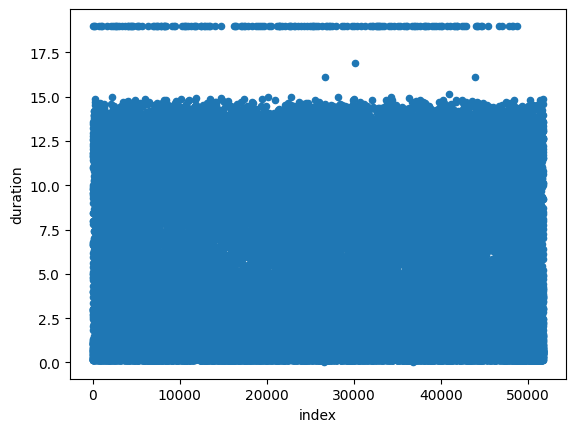

In [8]:
data.reset_index().plot(kind="scatter", x="index", y="duration")

In [9]:
data["duration"].describe()

count    51783.000000
mean         5.476842
std          4.751795
min          0.030000
25%          0.900000
50%          4.000000
75%         10.080000
max         19.000000
Name: duration, dtype: float64

In [10]:
(data["duration"] < 0.3).sum()

np.int64(3889)

In [11]:
data = data[(data["duration"] >= 0.3)]
bad_user = bad_user[(bad_user["duration"] >= 0.3)]
print(data.shape)
bad_user.shape

(47894, 8)


(47894, 8)

# bad user those row that have user time taken < duration

In [12]:
bad_user = bad_user[(bad_user["time_taken_by_user"] < bad_user["duration"])]

bad_user.shape

(5954, 8)

# remove non hindi user string as its for indian language

In [13]:
import re

def is_hindi_strict(text):
    if not text or text.strip() == "":
        return False
    # Remove spaces and punctuation
    cleaned = re.sub(r'[\s\.,\[\]\(\)!?\'"-]', '', text)
    # Check if all remaining characters are Hindi
    return all('\u0900' <= c <= '\u097F' for c in cleaned)

In [14]:
print(is_hindi_strict("नमस्ते"))        # True
print(is_hindi_strict("नमस्ते hello"))  # False
print(is_hindi_strict(","))  

True
False
True


In [15]:
data['user_text'] = data['user_text'].fillna('')
data['user_text'] = data['user_text'].astype(str)

(data['user_text']).describe()


count       47894
unique      33081
top       [blank]
freq         6326
Name: user_text, dtype: object

In [16]:
data = data[data['user_text'].apply(is_hindi_strict)]  # Apply the function and filter the rows
data.shape  # Returns the shape of the filtered DataFrame


(39598, 8)

In [17]:
data.shape

(39598, 8)

# remove those entry where user text length is not compatible with duration


In [18]:
data["char/duration"] = data["user_text"].str.len() / data["duration"].replace(0 , 0.0000000001)

data.shape

(39598, 9)

<Axes: xlabel='index', ylabel='char/duration'>

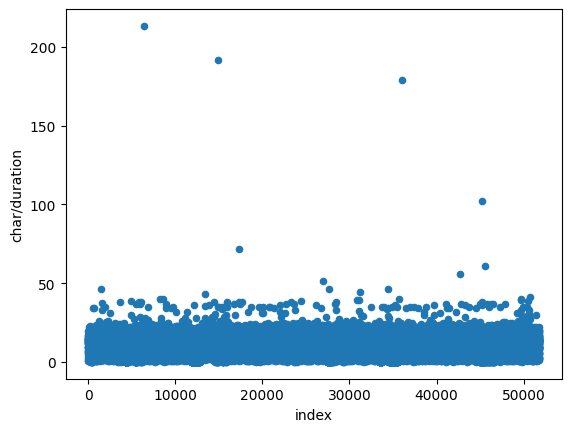

In [19]:
data.reset_index().plot(kind="scatter", x="index", y="char/duration")


In [20]:
temp = data[((data["char/duration"] < 3) | (data["char/duration"] > 30))]
data = data[((data["char/duration"] >= 3) & (data["char/duration"] <= 30))]
bad_user = pd.concat([bad_user ,temp] , ignore_index = True)

print(data.shape , temp.shape)

data["char/duration"].describe()

(36170, 9) (3428, 9)


count    36170.000000
mean        12.619421
std          4.401246
min          3.003003
25%          9.619828
50%         13.181818
75%         15.600000
max         30.000000
Name: char/duration, dtype: float64

In [21]:
bad_user.shape

(9382, 9)

# remove those user having abnormally high typing speed that reflects non human activity or spam

In [22]:
data[data["time_taken_by_user"].isna()]

,user_id,recording_url,whisper_text,user_text,is_edited,duration,time_taken_by_user,segment_character_per_second,char/duration
288,71953396,https://storage.googleapis.com/joshtalks-data-...,हमने सोचा कि अब जैसे जैसे सफर आगे बढ़ता जा ही ...,बहुत हमने सोचा कि अब जैसे जैसे सफर आगे बढ़ता ज...,Yes,19.00,NaN,10.842105,14.157895
723,71046139,https://storage.googleapis.com/joshtalks-data-...,अगला टॉपिक है पुजा या प्रार्थनाव अमिश्चामिल ह...,अगला टॉपिक है पुजा या प्रार्थनाऔ में श्मिशाल ...,Yes,10.98,NaN,12.204007,15.209472
903,58845056,https://storage.googleapis.com/joshtalks-data-...,NaN,जी ! जी जी जी पता है,Yes,2.76,NaN,5.072464,7.246377
1050,56629540,https://storage.googleapis.com/joshtalks-data-...,NaN,अब देने वाला देगा नहीं देने वाला कोई बात नई बा...,Yes,7.44,NaN,15.725806,20.295699
1197,74139549,https://storage.googleapis.com/joshtalks-data-...,"कुछ भी बना रहे हैं, अब तो गेम ही चल रही है, गे...","कुछ भी बना रहे हैं, अब तो गेम ही चल रही है, गे...",No,10.00,NaN,6.600000,8.800000
...,...,...,...,...,...,...,...,...,...
48249,56601149,https://storage.googleapis.com/joshtalks-data-...,NaN,और जल्दी से जल्दी निकलने की कोशिश करते है हाँ ...,Yes,8.07,NaN,6.195787,7.930607
48368,74798865,https://storage.googleapis.com/joshtalks-data-...,हमने सुना है कि बालाजी मंदिर में आप जो समान ले...,हमने सुना है कि बालाजी मंदिर में आप जो समान ले...,Yes,5.00,NaN,11.000000,14.400000
48480,74106376,https://storage.googleapis.com/joshtalks-data-...,"कुछ भी बना रहे हैं, अब तो गेम ही चल रही है, गे...","कुछ भी बना रहे हैं, अब तो गेम ही चल रही है, गे...",No,10.00,NaN,6.600000,8.800000
48617,74141996,https://storage.googleapis.com/joshtalks-data-...,"कुछ भी बना रहे हैं, अब तो गेम ही चल रही है, गे...","कि चाहे कुछ भी बना रहे हैं, अब तो गेम ही चल रह...",Yes,10.00,NaN,12.200000,16.100000


In [23]:
data["time_taken_by_user"] = data["time_taken_by_user"] - data["duration"]

In [24]:
data[data["time_taken_by_user"].isna()]

,user_id,recording_url,whisper_text,user_text,is_edited,duration,time_taken_by_user,segment_character_per_second,char/duration
288,71953396,https://storage.googleapis.com/joshtalks-data-...,हमने सोचा कि अब जैसे जैसे सफर आगे बढ़ता जा ही ...,बहुत हमने सोचा कि अब जैसे जैसे सफर आगे बढ़ता ज...,Yes,19.00,NaN,10.842105,14.157895
723,71046139,https://storage.googleapis.com/joshtalks-data-...,अगला टॉपिक है पुजा या प्रार्थनाव अमिश्चामिल ह...,अगला टॉपिक है पुजा या प्रार्थनाऔ में श्मिशाल ...,Yes,10.98,NaN,12.204007,15.209472
903,58845056,https://storage.googleapis.com/joshtalks-data-...,NaN,जी ! जी जी जी पता है,Yes,2.76,NaN,5.072464,7.246377
1050,56629540,https://storage.googleapis.com/joshtalks-data-...,NaN,अब देने वाला देगा नहीं देने वाला कोई बात नई बा...,Yes,7.44,NaN,15.725806,20.295699
1197,74139549,https://storage.googleapis.com/joshtalks-data-...,"कुछ भी बना रहे हैं, अब तो गेम ही चल रही है, गे...","कुछ भी बना रहे हैं, अब तो गेम ही चल रही है, गे...",No,10.00,NaN,6.600000,8.800000
...,...,...,...,...,...,...,...,...,...
48249,56601149,https://storage.googleapis.com/joshtalks-data-...,NaN,और जल्दी से जल्दी निकलने की कोशिश करते है हाँ ...,Yes,8.07,NaN,6.195787,7.930607
48368,74798865,https://storage.googleapis.com/joshtalks-data-...,हमने सुना है कि बालाजी मंदिर में आप जो समान ले...,हमने सुना है कि बालाजी मंदिर में आप जो समान ले...,Yes,5.00,NaN,11.000000,14.400000
48480,74106376,https://storage.googleapis.com/joshtalks-data-...,"कुछ भी बना रहे हैं, अब तो गेम ही चल रही है, गे...","कुछ भी बना रहे हैं, अब तो गेम ही चल रही है, गे...",No,10.00,NaN,6.600000,8.800000
48617,74141996,https://storage.googleapis.com/joshtalks-data-...,"कुछ भी बना रहे हैं, अब तो गेम ही चल रही है, गे...","कि चाहे कुछ भी बना रहे हैं, अब तो गेम ही चल रह...",Yes,10.00,NaN,12.200000,16.100000


In [25]:
data["time_taken_by_user"].describe()

count    36011.000000
mean       185.746939
std       1537.634293
min        -19.000000
25%          4.265314
50%         15.665122
75%         57.939647
max      72803.269227
Name: time_taken_by_user, dtype: float64

<Axes: xlabel='index', ylabel='time_taken_by_user'>

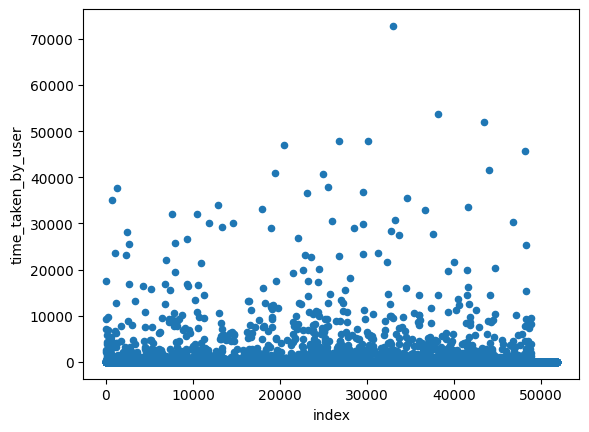

In [26]:
data.reset_index().plot(kind="scatter", x="index", y="time_taken_by_user")

In [27]:
data["whisper_text"] = data["whisper_text"].fillna("")

data.head()

,user_id,recording_url,whisper_text,user_text,is_edited,duration,time_taken_by_user,segment_character_per_second,char/duration
0,71275781,https://storage.googleapis.com/joshtalks-data-...,इन जॉब में तो बहुत पैसे कमा है आपने,इन जॉब में तो बहुत पैसे कमा है आपने,No,2.94,12.060000,9.183673,12.244898
1,71275800,https://storage.googleapis.com/joshtalks-data-...,,हूं,Yes,0.96,13.297711,3.125000,4.166667
2,71275813,https://storage.googleapis.com/joshtalks-data-...,तो उसमें एक मन एक मंत की सैल्वी उसमें आठ लिया...,तो उसमें एक मन एक मंत की सैलरी उसमें आठ लिया ...,Yes,4.83,16.024130,7.867495,10.351967
3,71275842,https://storage.googleapis.com/joshtalks-data-...,,हूं,Yes,0.45,8.010025,6.666667,8.888889
5,71274726,https://storage.googleapis.com/joshtalks-data-...,पर विगराम कोई ने कोई मिल जाता है दिरीदर दोस्त...,पर विगराम कोई ने कोई मिल जाता है दिरीदर दोस्त...,No,8.43,15.818714,11.387900,14.472123


# ****function to get user typing speed****

In [28]:
import math

import Levenshtein

def typing_speed(str_old, str_new, time_seconds):
    # Calculate the Levenshtein distance (edit distance)
    edit_distance = Levenshtein.distance(str_old, str_new)
    
    # You can calculate the typing effort by dividing the edit distance by the time taken
    typing_speed_value = edit_distance / time_seconds

    # Print results
    # print(f"Levenshtein Distance (Edit Effort): {edit_distance}")
    # print(f"Typing Speed (effort per second): {typing_speed_value:.2f} edits/sec")
    return typing_speed_value



In [29]:
# Simple correction
# typing_speed("helo", "hello", 2.0)

# Long contiguous deletion
typing_speed("hellooooooooo", "hello", 1.0)

# Scattered deletions and substitutions
typing_speed("hlllreoooo wqorlld", "hello world", 1.0)

# Spaces involved
typing_speed("hello  world", "hello world", 1.5)

typing_speed("", "Hello world", 5)
typing_speed("Hello world", "", 4)
typing_speed("Hillo world", "Hello world", 2)
typing_speed("Hlllreoooo wqorlld", "hello world", 5)
typing_speed("", "हम्म आ सम्मान्य समय मे तो कैसे भी सम्मान्य समय धीरे धीरे कट जाता है दोस्तों से बात करके आ ऐसे ही कुछ भी करके लेकिन जो त्यौहार वाला समय होता है वह बहुत खास समय होता है वह परिवार के साथ बिताने वाला पल होता है", 330.384553)
typing_speed(" जबकि उनको भी motivate करना चाहिए और अपने को भी ऐसे खुश रहना चाहिए हम भी उनको उनसे कुछ सीख ले उनकी तरह बने यू नहीं कि उनकी टांग खीचे यू उनको नीचे दिखाने का ट्राइ करें",
             "जबकि उनको भी मोटिवेट करना चाहिए और अपने को भी ऐसे खुश रहना चाहिए हम भी उनको उनसे कुछ सीख ले उनकी तरह बने यू नहीं कि उनकी टांग खीचे यू उनको नीचे दिखाने का ट्राइ करें" , 2.05)


4.390243902439025

In [30]:
data[(data["time_taken_by_user"] == 0)]

,user_id,recording_url,whisper_text,user_text,is_edited,duration,time_taken_by_user,segment_character_per_second,char/duration


In [31]:
# Example: if you have a column "time_taken" with typing time in seconds
data["user_typing_speed"] = data.apply(
    lambda x: typing_speed(str(x["whisper_text"]), str(x["user_text"]), x["time_taken_by_user"]),
    axis=1
)

data.head()

,user_id,recording_url,whisper_text,user_text,is_edited,duration,time_taken_by_user,segment_character_per_second,char/duration,user_typing_speed
0,71275781,https://storage.googleapis.com/joshtalks-data-...,इन जॉब में तो बहुत पैसे कमा है आपने,इन जॉब में तो बहुत पैसे कमा है आपने,No,2.94,12.060000,9.183673,12.244898,0.000000
1,71275800,https://storage.googleapis.com/joshtalks-data-...,,हूं,Yes,0.96,13.297711,3.125000,4.166667,0.300804
2,71275813,https://storage.googleapis.com/joshtalks-data-...,तो उसमें एक मन एक मंत की सैल्वी उसमें आठ लिया...,तो उसमें एक मन एक मंत की सैलरी उसमें आठ लिया ...,Yes,4.83,16.024130,7.867495,10.351967,0.124812
3,71275842,https://storage.googleapis.com/joshtalks-data-...,,हूं,Yes,0.45,8.010025,6.666667,8.888889,0.499374
5,71274726,https://storage.googleapis.com/joshtalks-data-...,पर विगराम कोई ने कोई मिल जाता है दिरीदर दोस्त...,पर विगराम कोई ने कोई मिल जाता है दिरीदर दोस्त...,No,8.43,15.818714,11.387900,14.472123,0.000000


In [32]:
data.head()

,user_id,recording_url,whisper_text,user_text,is_edited,duration,time_taken_by_user,segment_character_per_second,char/duration,user_typing_speed
0,71275781,https://storage.googleapis.com/joshtalks-data-...,इन जॉब में तो बहुत पैसे कमा है आपने,इन जॉब में तो बहुत पैसे कमा है आपने,No,2.94,12.060000,9.183673,12.244898,0.000000
1,71275800,https://storage.googleapis.com/joshtalks-data-...,,हूं,Yes,0.96,13.297711,3.125000,4.166667,0.300804
2,71275813,https://storage.googleapis.com/joshtalks-data-...,तो उसमें एक मन एक मंत की सैल्वी उसमें आठ लिया...,तो उसमें एक मन एक मंत की सैलरी उसमें आठ लिया ...,Yes,4.83,16.024130,7.867495,10.351967,0.124812
3,71275842,https://storage.googleapis.com/joshtalks-data-...,,हूं,Yes,0.45,8.010025,6.666667,8.888889,0.499374
5,71274726,https://storage.googleapis.com/joshtalks-data-...,पर विगराम कोई ने कोई मिल जाता है दिरीदर दोस्त...,पर विगराम कोई ने कोई मिल जाता है दिरीदर दोस्त...,No,8.43,15.818714,11.387900,14.472123,0.000000


In [33]:
data[data["time_taken_by_user"].isna()]

,user_id,recording_url,whisper_text,user_text,is_edited,duration,time_taken_by_user,segment_character_per_second,char/duration,user_typing_speed
288,71953396,https://storage.googleapis.com/joshtalks-data-...,हमने सोचा कि अब जैसे जैसे सफर आगे बढ़ता जा ही ...,बहुत हमने सोचा कि अब जैसे जैसे सफर आगे बढ़ता ज...,Yes,19.00,NaN,10.842105,14.157895,NaN
723,71046139,https://storage.googleapis.com/joshtalks-data-...,अगला टॉपिक है पुजा या प्रार्थनाव अमिश्चामिल ह...,अगला टॉपिक है पुजा या प्रार्थनाऔ में श्मिशाल ...,Yes,10.98,NaN,12.204007,15.209472,NaN
903,58845056,https://storage.googleapis.com/joshtalks-data-...,,जी ! जी जी जी पता है,Yes,2.76,NaN,5.072464,7.246377,NaN
1050,56629540,https://storage.googleapis.com/joshtalks-data-...,,अब देने वाला देगा नहीं देने वाला कोई बात नई बा...,Yes,7.44,NaN,15.725806,20.295699,NaN
1197,74139549,https://storage.googleapis.com/joshtalks-data-...,"कुछ भी बना रहे हैं, अब तो गेम ही चल रही है, गे...","कुछ भी बना रहे हैं, अब तो गेम ही चल रही है, गे...",No,10.00,NaN,6.600000,8.800000,NaN
...,...,...,...,...,...,...,...,...,...,...
48249,56601149,https://storage.googleapis.com/joshtalks-data-...,,और जल्दी से जल्दी निकलने की कोशिश करते है हाँ ...,Yes,8.07,NaN,6.195787,7.930607,NaN
48368,74798865,https://storage.googleapis.com/joshtalks-data-...,हमने सुना है कि बालाजी मंदिर में आप जो समान ले...,हमने सुना है कि बालाजी मंदिर में आप जो समान ले...,Yes,5.00,NaN,11.000000,14.400000,NaN
48480,74106376,https://storage.googleapis.com/joshtalks-data-...,"कुछ भी बना रहे हैं, अब तो गेम ही चल रही है, गे...","कुछ भी बना रहे हैं, अब तो गेम ही चल रही है, गे...",No,10.00,NaN,6.600000,8.800000,NaN
48617,74141996,https://storage.googleapis.com/joshtalks-data-...,"कुछ भी बना रहे हैं, अब तो गेम ही चल रही है, गे...","कि चाहे कुछ भी बना रहे हैं, अब तो गेम ही चल रह...",Yes,10.00,NaN,12.200000,16.100000,NaN


In [34]:
data[((data["is_edited"] == "No") & (data["user_typing_speed"] != 0))]

,user_id,recording_url,whisper_text,user_text,is_edited,duration,time_taken_by_user,segment_character_per_second,char/duration,user_typing_speed
1197,74139549,https://storage.googleapis.com/joshtalks-data-...,"कुछ भी बना रहे हैं, अब तो गेम ही चल रही है, गे...","कुछ भी बना रहे हैं, अब तो गेम ही चल रही है, गे...",No,10.00,NaN,6.600000,8.800000,NaN
3346,72280806,https://storage.googleapis.com/joshtalks-data-...,हमने सोचा कि अब जैसे जैसे सफर आगे बढ़ता जा ही ...,हमने सोचा कि अब जैसे जैसे सफर आगे बढ़ता जा ही ...,No,19.00,NaN,7.052632,9.157895,NaN
4372,72341413,https://storage.googleapis.com/joshtalks-data-...,हमने सोचा कि अब जैसे जैसे सफर आगे बढ़ता जा ही ...,हमने सोचा कि अब जैसे जैसे सफर आगे बढ़ता जा ही ...,No,19.00,NaN,7.052632,9.157895,NaN
5324,71275692,https://storage.googleapis.com/joshtalks-data-...,लोकल स्पोर्ट्स लिंग में शामिल होने की योजना ब...,लोकल स्पोर्ट्स लिंग में शामिल होने की योजना ब...,No,5.19,NaN,12.524085,15.414258,NaN
8130,71110363,https://storage.googleapis.com/joshtalks-data-...,आपके साथ ऐसा भी होता होगा कि आपके ओ बीच में ऐस...,आपके साथ ऐसा भी होता होगा कि आपके ओ बीच में ऐस...,No,13.00,NaN,6.692308,8.538462,NaN
9253,71201446,https://storage.googleapis.com/joshtalks-data-...,नजारे होते हैं वो सब देखने नहीं मिलते हैं वो ...,नजारे होते हैं वो सब देखने नहीं मिलते हैं वो ...,No,2.91,NaN,17.525773,22.680412,NaN
16449,72143100,https://storage.googleapis.com/joshtalks-data-...,आपके साथ ऐसा भी होता होगा कि आपके ओ बीच में ऐस...,आपके साथ ऐसा भी होता होगा कि आपके ओ बीच में ऐस...,No,13.00,NaN,6.692308,8.538462,NaN
22629,72174022,https://storage.googleapis.com/joshtalks-data-...,हमने सोचा कि अब जैसे जैसे सफर आगे बढ़ता जा ही ...,हमने सोचा कि अब जैसे जैसे सफर आगे बढ़ता जा ही ...,No,19.00,NaN,7.052632,9.157895,NaN
23579,71103847,https://storage.googleapis.com/joshtalks-data-...,बैठी हुए है अगर पीछे से कोई पकड़ा हुआ है तो उस...,बैठी हुए है अगर पीछे से कोई पकड़ा हुआ है तो उस...,No,8.00,NaN,7.250000,9.500000,NaN
27529,72409311,https://storage.googleapis.com/joshtalks-data-...,हमने सोचा कि अब जैसे जैसे सफर आगे बढ़ता जा ही ...,हमने सोचा कि अब जैसे जैसे सफर आगे बढ़ता जा ही ...,No,19.00,NaN,7.052632,9.157895,NaN


In [35]:
data["user_typing_speed"].describe()

count    36011.000000
mean        -0.863130
std        175.124012
min     -25326.000000
25%          0.013613
50%          0.397004
75%          1.061538
max       8246.000000
Name: user_typing_speed, dtype: float64

<Axes: xlabel='index', ylabel='user_typing_speed'>

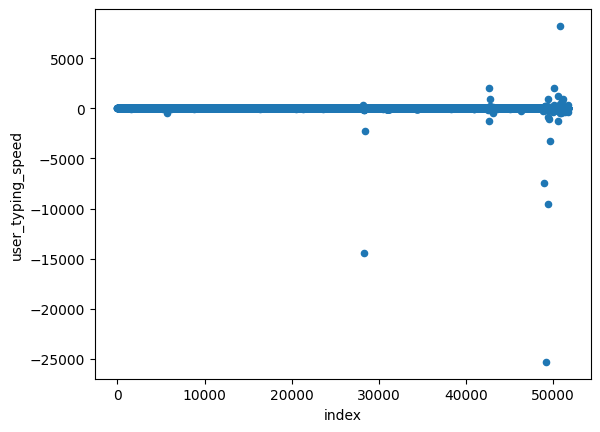

In [36]:
data.reset_index().plot(kind="scatter", x="index", y="user_typing_speed")

C:\Users\Anirban Das\AppData\Local\Temp\ipykernel_19888\4139297378.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data["user_typing_speed"], shade=True, color="blue", alpha=0.5)


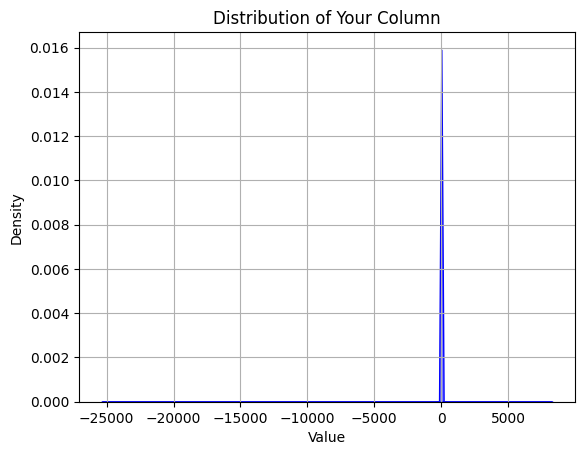

In [37]:
sns.kdeplot(data["user_typing_speed"], shade=True, color="blue", alpha=0.5)

# Customize the plot
plt.title("Distribution of Your Column")
plt.xlabel("Value")
plt.ylabel("Density")
plt.grid(True)
plt.show()

In [38]:
data[data["user_typing_speed"] > 50].head()

,user_id,recording_url,whisper_text,user_text,is_edited,duration,time_taken_by_user,segment_character_per_second,char/duration,user_typing_speed
1317,71048909,https://storage.googleapis.com/joshtalks-data-...,अब दोस्तों के साथ अभ्यास करना तो मतलब एक होता...,एक्चुअली घर में अब दोस्तों के साथ अभ्यास करना...,Yes,14.13,0.191576,7.926398,10.261854,83.517768
5452,72581286,https://storage.googleapis.com/joshtalks-data-...,आजकल लोग क्या करते हैं वीडियो बनाते हैं एंटरेट...,हांजी हांजी आजकल लोग क्या करते हैं वीडियो बना...,Yes,9.00,0.250498,9.222222,11.333333,55.888670
5764,71778339,https://storage.googleapis.com/joshtalks-data-...,जी जी जी बिलकुल बिलकुल हमारी आवाज आ रही है,जी जी जी बिलकुल बिलकुल हमारी आवाज आ रही है।,Yes,3.15,0.019759,10.793651,13.968254,50.609849
28130,56633474,https://storage.googleapis.com/joshtalks-data-...,,ऊपर से एक चम्मच मक्खन डाल देते तो कभी-कभी,Yes,11.34,0.441128,2.910053,3.615520,92.943545
28186,56659520,https://storage.googleapis.com/joshtalks-data-...,,यह होता है कि किसी भी स्थान पर आप काम कररहे हैं,Yes,11.85,0.142383,3.037975,3.966245,330.095587


In [39]:
data.sort_values(by="user_typing_speed" , ascending = False).head(20)

,user_id,recording_url,whisper_text,user_text,is_edited,duration,time_taken_by_user,segment_character_per_second,char/duration,user_typing_speed
50869,681509,https://storage.googleapis.com/joshtalks-data-...,और इसमें जो फिर अपना next topic आ जाता है कि घ...,हा इसमें जो फिर अपना नेक्स्ट टॉपिक आ जाता है क...,Yes,8.998302,0.001698,11.780000,15.002830,8246.000000
50186,632098,https://storage.googleapis.com/joshtalks-data-...,,यह मैडम हमारा रिसीवर अब आप मैडम यह बताइए हमारा...,Yes,10.945274,0.054726,8.040000,10.415455,2083.090909
42677,65102944,https://storage.googleapis.com/joshtalks-data-...,,है और यह चीज है जो कि हम अपने परिवार को अपनी ब...,Yes,10.830000,0.056190,7.940905,10.526316,2028.830753
50550,580062,https://storage.googleapis.com/joshtalks-data-...,,वो सक्सेस को जल्दी पाना चाहते हैं जैसे इंस्टाग...,Yes,9.870919,0.129081,13.170000,16.513154,1262.770588
49400,580062,https://storage.googleapis.com/joshtalks-data-...,अच्छी लगती है बस कारण क्या है उसका कुछ नहीं उन...,अच्छी लगती है बस कारण क्या है उसका कुछ नहीं उन...,Yes,8.998989,0.001011,9.890000,12.779213,989.000000
42821,71767573,https://storage.googleapis.com/joshtalks-data-...,,जी ने इस तरह रिलेटेड कुछ ऐसे दोस्त होता कि वही...,Yes,6.090000,0.054633,6.568144,8.538588,951.805685
51151,681509,https://storage.googleapis.com/joshtalks-data-...,,आप किसी से नहीं होते हैं ना तो भी अकाउंट हो जा...,Yes,5.909091,0.090909,11.000000,14.046154,913.000000
51030,580062,https://storage.googleapis.com/joshtalks-data-...,,वहीं तो में वहीं तो मेरा भी तो साडू आया तो मेर...,Yes,7.861937,0.138063,10.430000,13.864268,789.493056
50810,580062,https://storage.googleapis.com/joshtalks-data-...,,फिर एक बार फिर से रिपीट कर सकते है एक्चुअली थो...,Yes,3.810119,0.189881,16.010000,20.471803,410.782895
50124,467270,https://storage.googleapis.com/joshtalks-data-...,ठीक है उन्हीं से मिनट के लिए कॉल को चलने लो फि...,ठीक है। हां उन्नीस मिनट के लिए कॉल को चलने लो...,Yes,10.951894,0.048106,9.770000,12.965794,374.170213
